In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [2]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 150

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 1500

# Number of weak classifiers
nbrWeakClassifiers = 30

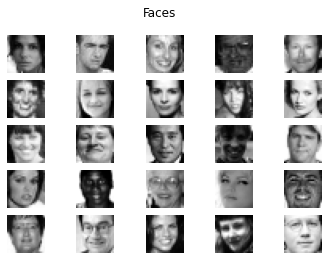

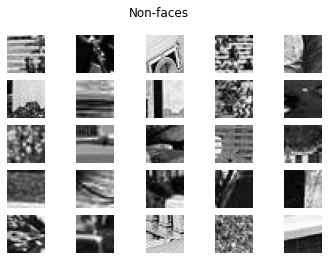

In [3]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

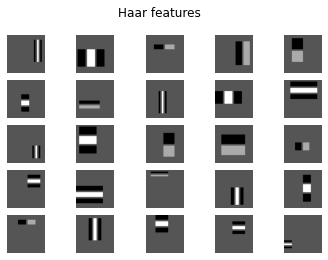

In [4]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [5]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))


# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))


# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [6]:
xTrain[0]

array([ 382.,  354.,  336., ...,  445.,  -18., -143.])

In [7]:
xTest.shape

(150, 11288)

In [8]:
def adaBoost(X,Y, num_classifiers):
    
    nfeatures, nsamples = X.shape
    weights = 1.0/len(Y)
    classifier = []
    errors = []
    features = []
    thres_list = []
    Polar_list = []
    alpha_list =[]
    
    # First loop for the number of classifiers
    for classifiers in range(num_classifiers):
        
        min_loss = float('inf')
        
        # Second loop to go over every feature
        for feat in range(nfeatures):

            feature = X[feat,:]

            thresholds = np.unique(feature)

            # third loop to go over every threshold
            for thres in thresholds:
                p=1
                preds=np.ones(nsamples)
                preds[feature<thres]=-1

                loss = WeakClassifierError(C = preds, D = weights, Y =Y)

                if loss > 0.5:
                    p = -1
                    loss = 1-loss

                if loss < min_loss:
                    min_loss = loss
                    T = thres
                    P = p
                    feature_idx = feat
                    
        EPS = 1e-15
        alpha_t = 0.5*np.log((1.0-min_loss+EPS)/(min_loss+EPS))
        prediction = WeakClassifier(T , P , X = X[feature_idx,:])
        features.append(feature_idx)
        thres_list.append(T)
        Polar_list.append(P)
        alpha_list.append(alpha_t)
        weights = weights * np.exp(-alpha_t * Y * prediction)
        weights = weights / np.sum(weights)
        classifier.append(alpha_t*prediction)
        errors.append(sum((np.sign(np.sum(classifier, axis=0)) !=Y))/len(Y))
        

    return np.sign(np.sum(classifier, axis=0)), errors, features, thres_list, Polar_list, alpha_list   
    

In [22]:
num_classifier = 50

In [23]:
train_pred, losses, final_feat, final_thres, final_pol, final_alpha = adaBoost(xTrain,yTrain,num_classifier)

In [12]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.

def predict(X,Y,num_classifier, final_alpha, final_thres, final_pol, final_feat):
    
    clf_preds = [final_alpha[i] * WeakClassifier(final_thres[i], final_pol[i], X[final_feat[i],:]) for i in range(num_classifier)]
    pred = np.sum(clf_preds,axis=0)
    pred = np.sign(pred)
    
    return pred, sum(pred == Y)/len(Y)
    
    

In [24]:
train_predictions, train_accuracy = predict(xTrain, yTrain, num_classifier, final_alpha, final_thres, final_pol, final_feat)

In [25]:
train_accuracy

0.98

In [26]:
test_predictions, test_accuracy = predict(xTest, yTest, num_classifier, final_alpha, final_thres, final_pol, final_feat)

In [27]:
test_accuracy

0.9399362154500355

In [31]:
train_acc =[]
test_acc = []
for i in range(51):
    train_acc.append(predict(xTrain, yTrain, i, final_alpha, final_thres, final_pol, final_feat)[1])
    test_acc.append(predict(xTest, yTest, i, final_alpha, final_thres, final_pol, final_feat)[1])


Text(0.5, 0.98, 'Accuracy based on number of classifiers')

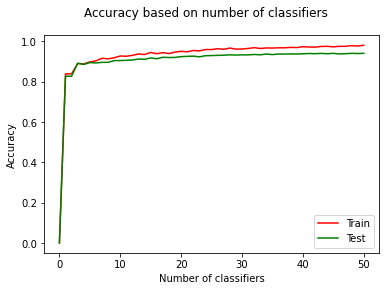

In [33]:
plt.plot(list(range(51)), train_acc, 'r', label='Train')
plt.legend()
plt.plot(list(range(51)), test_acc, 'g' ,label = 'Test')
plt.legend()
plt.xlabel('Number of classifiers')
plt.ylabel('Accuracy')
plt.suptitle('Accuracy based on number of classifiers')

Text(0, 0.5, 'Error for strong classifer')

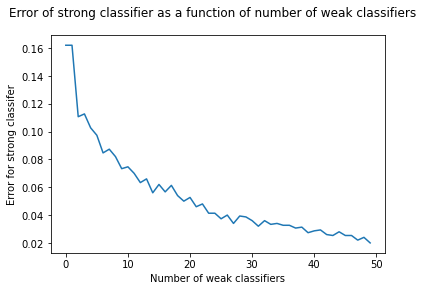

In [36]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.

plt.plot(list(range(num_classifier)), losses)
plt.suptitle('Error of strong classifier as a function of number of weak classifiers')
plt.xlabel('Number of weak classifiers')
plt.ylabel('Error for strong classifer')

Text(0.5, 0.98, 'Non-Faces predicted as Faces')

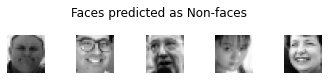

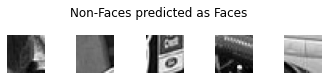

In [38]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.


plt.figure()
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,(np.where(test_predictions != yTest)[0][:30]+750)[i]], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces predicted as Non-faces')

plt.figure()
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,list(np.array([4191,  4208,  4213,  4218,  4242])-4166 + 750)[i]], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-Faces predicted as Faces')

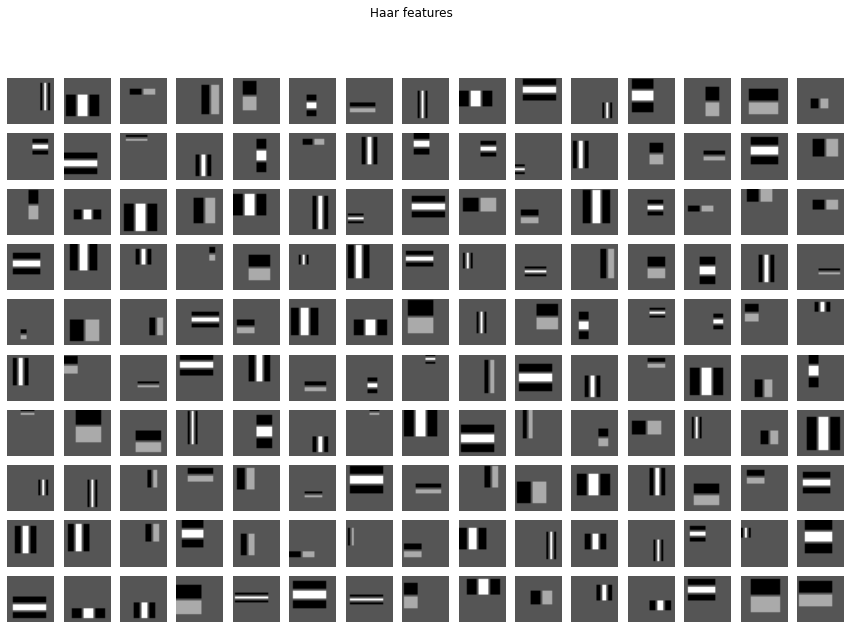

In [39]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.

plt.figure(figsize=(15,10))
for k in range(150):
    plt.subplot(10,15,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()